# Number of model 2 cluster hits per sample

In [1]:
from malid import helpers, config
from malid.datamodels import *

In [2]:
from malid.trained_model_wrappers import ConvergentClusterClassifier

In [3]:
from malid import io

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [5]:
import genetools

In [6]:
target_obs_column = TargetObsColumnEnum.disease

In [7]:
# Load each fold's model2 and held-out test set
# Count disease-specific model2 cluster hits for each held-out test sample

featurized_datas = {}
for gene_locus in config.gene_loci_used:
    for fold_id in config.cross_validation_fold_ids:
        clf = ConvergentClusterClassifier(
            fold_id=fold_id,
            model_name=config.metamodel_base_model_names.model_name_convergent_clustering[
                gene_locus
            ],
            fold_label_train="train_smaller1",
            gene_locus=gene_locus,
            target_obs_column=target_obs_column,
        )
        adata = io.load_fold_embeddings(
            fold_id=fold_id,
            fold_label="test",
            gene_locus=gene_locus,
            target_obs_column=target_obs_column,
            load_obs_only=True,
        )
        featurized_datas[(gene_locus, fold_id)] = clf.featurize(adata)
        print(gene_locus, fold_id)
        io.clear_cached_fold_embeddings()

GeneLocus.BCR 0
GeneLocus.BCR 1
GeneLocus.BCR 2
GeneLocus.TCR 0
GeneLocus.TCR 1
GeneLocus.TCR 2


In [8]:
# Review some of the data manually

In [9]:
gene_locus = GeneLocus.BCR
fold_id = 0
fd = featurized_datas[gene_locus, 0]

In [10]:
fd.X

cluster_dominant_label,Covid19,HIV,Healthy/Background,Influenza,Lupus,T1D
specimen_label,,,,,,
M111-S037,0.0,13.0,1.0,1.0,11.0,0.0
M124-S042,0.0,0.0,2.0,4.0,5.0,0.0
M111-S016,1.0,19.0,1.0,2.0,8.0,0.0
M111-S043,0.0,24.0,1.0,0.0,4.0,0.0
M124-S036,0.0,5.0,1.0,2.0,3.0,0.0
...,...,...,...,...,...,...
M491-S146,0.0,3.0,1.0,0.0,3.0,0.0
M491-S148,0.0,0.0,2.0,1.0,2.0,0.0
M491-S149,0.0,1.0,4.0,5.0,1.0,1.0


In [11]:
fd.y

specimen_label
M111-S037                   HIV
M124-S042    Healthy/Background
M111-S016                   HIV
M111-S043                   HIV
M124-S036    Healthy/Background
                    ...        
M491-S146                   T1D
M491-S148                   T1D
M491-S149                   T1D
M491-S153                   T1D
M491-S160                   T1D
Name: disease, Length: 205, dtype: category
Categories (6, object): ['HIV', 'Healthy/Background', 'Lupus', 'Covid19', 'Influenza', 'T1D']

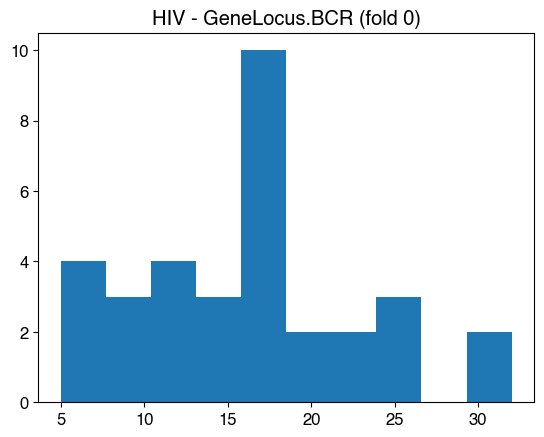

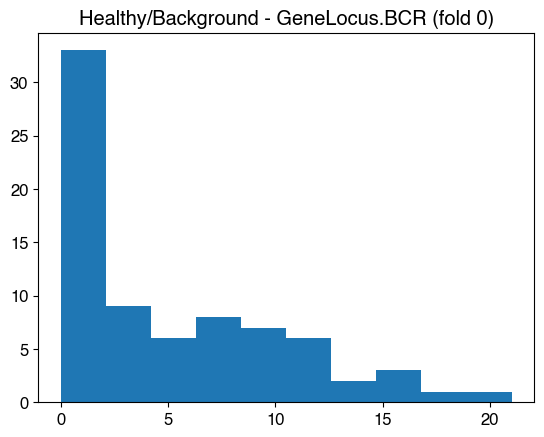

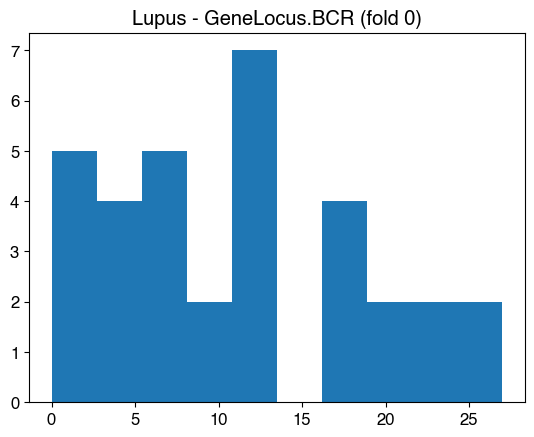

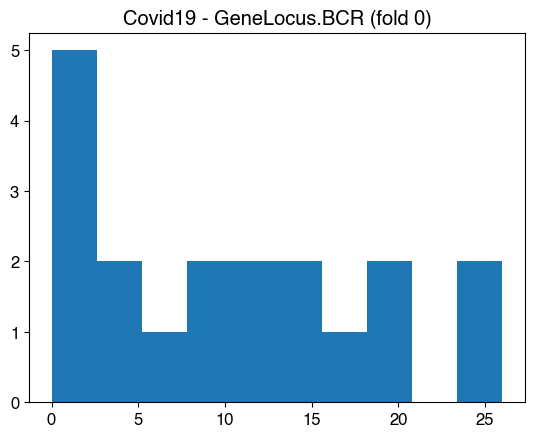

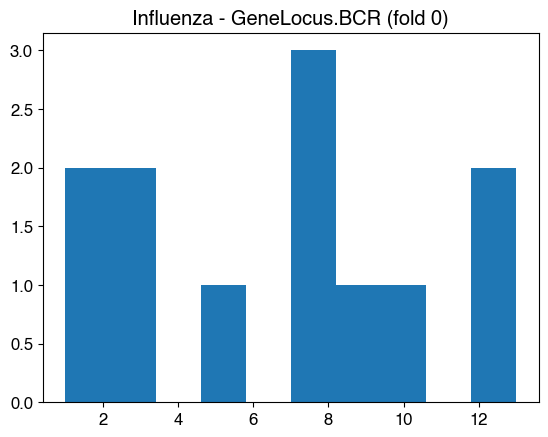

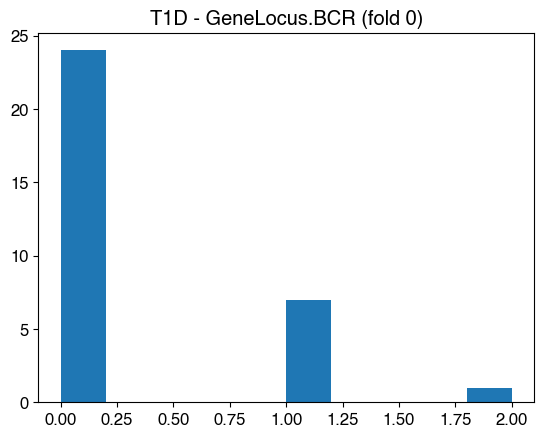

In [12]:
for disease in fd.y.unique():
    plt.figure()
    plt.hist(fd.X.loc[fd.y == disease, disease])
    plt.title(f"{disease} - {gene_locus} (fold {fold_id})")

In [13]:
# Plot it all

In [14]:
all_diseases = clf.classes_
all_diseases = all_diseases[all_diseases != healthy_label]
all_diseases

array(['Covid19', 'HIV', 'Influenza', 'Lupus', 'T1D'], dtype=object)

In [15]:
len(featurized_datas)

6

In [16]:
featurized_datas.keys()

dict_keys([(<GeneLocus.BCR: 1>, 0), (<GeneLocus.BCR: 1>, 1), (<GeneLocus.BCR: 1>, 2), (<GeneLocus.TCR: 2>, 0), (<GeneLocus.TCR: 2>, 1), (<GeneLocus.TCR: 2>, 2)])

/users/maximz/code/boyd-immune-repertoire-classification/out/in_house_peak_disease_timepoints/convergent_clusters/cluster_hits_per_sample.disease.png


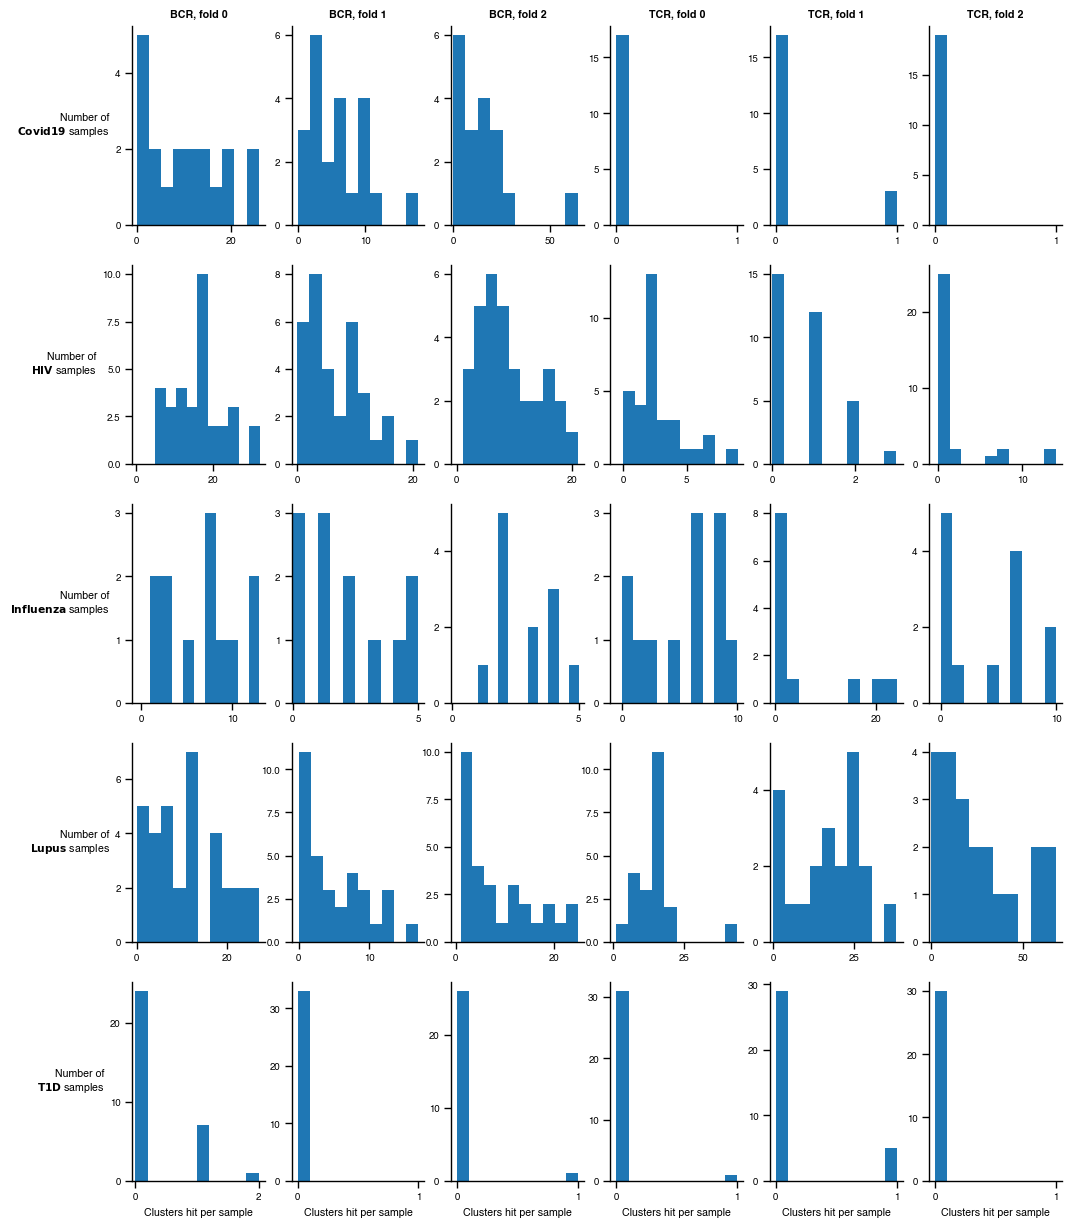

In [18]:
with sns.plotting_context("paper", font_scale=0.8):
    fig, axarr = plt.subplots(
        nrows=len(all_diseases), ncols=len(featurized_datas), figsize=(12, 15)
    )
    for ix_col, ((gene_locus, fold_id), fd) in enumerate(featurized_datas.items()):
        for ix_row, disease in enumerate(all_diseases):
            ax = axarr[ix_row, ix_col]
            data_for_this_ax = fd.X.loc[fd.y == disease, disease]
            ax.hist(data_for_this_ax)

            if max(data_for_this_ax) > 5:
                ax.set_xlim(
                    -1,
                )
            else:
                ax.set_xlim(
                    -0.05,
                )

            if max(data_for_this_ax) == 0:
                # If the only entry is 0, make the xticks reasonable
                ax.set_xticks([0, 1])
                ax.set_xlim(-0.05, 1.05)

            if ix_row == 0:
                ax.set_title(f"{gene_locus.name}, fold {fold_id}", fontweight="bold")
            if ix_col == 0:
                ax.set_ylabel(
                    "Number of\n" r"$\bf{" + f"{disease}" + r"}$" + " samples",
                    rotation=0,
                    ha="right",
                    va="center",
                )

            sns.despine(ax=ax)

    for ax in axarr[-1, :]:
        ax.set_xlabel("Clusters hit per sample")

    plot_fname = (
        config.paths.convergent_clusters_output_dir
        / f"cluster_hits_per_sample.{target_obs_column.name}.png"
    )
    genetools.plots.savefig(fig, plot_fname, dpi=300)
    print(plot_fname)

In [22]:
# How many patients (samples, really) from each disease have at least 1 cluster hit from that disease?
how_many_have_at_least_one_hit = []
for (gene_locus, fold_id), fd in featurized_datas.items():
    for disease in all_diseases:
        how_many_have_at_least_one_hit.append(
            dict(
                gene_locus=gene_locus.name,
                fold_id=fold_id,
                disease=disease,
                count=(fd.X.loc[fd.y == disease, disease] > 0).sum(),
            )
        )
pd.DataFrame(how_many_have_at_least_one_hit).pivot(
    index=["gene_locus", "fold_id"], columns="disease", values="count"
)

disease             Covid19  HIV  Influenza  Lupus  T1D
gene_locus fold_id                                     
BCR        0             15   33         12     31    8
           1             20   32          9     29    0
           2             16   32         12     29    1
TCR        0              0   28         10     22    1
           1              3   18          7     20    5
           2              0   17          8     19    0

In [ ]:
# What percentage of patients (samples, really) from each disease have at least 1 cluster hit from that disease?
how_many_have_at_least_one_hit = []
for (gene_locus, fold_id), fd in featurized_datas.items():
    for disease in all_diseases:
        how_many_have_at_least_one_hit.append(
            dict(
                gene_locus=gene_locus.name,
                fold_id=fold_id,
                disease=disease,
                count=(fd.X.loc[fd.y == disease, disease] > 0).mean(),
            )
        )

In [29]:
pd.DataFrame(how_many_have_at_least_one_hit).pivot(
    index=["gene_locus", "fold_id"], columns="disease", values="count"
) * 100

disease               Covid19         HIV   Influenza       Lupus        T1D
gene_locus fold_id                                                          
BCR        0        78.947368  100.000000  100.000000   93.939394  25.000000
           1        90.909091   96.969697   75.000000   87.878788   0.000000
           2        88.888889  100.000000  100.000000  100.000000   3.703704
TCR        0         0.000000   84.848485   83.333333  100.000000   3.125000
           1        15.000000   54.545455   58.333333   95.238095  14.705882
           2         0.000000   53.125000   61.538462   90.476190   0.000000

# Extract number of predictive clusters for each disease from model 2

In [26]:
predictive_cluster_counts = {}
for gene_locus in config.gene_loci_used:
    for fold_id in config.cross_validation_fold_ids:
        clftmp = ConvergentClusterClassifier(
            fold_id=fold_id,
            model_name=config.metamodel_base_model_names.model_name_convergent_clustering[
                gene_locus
            ],
            fold_label_train="train_smaller1",
            gene_locus=gene_locus,
            target_obs_column=target_obs_column,
        )
        # Get all clusters
        model2_cluster_class_associations = (
            clftmp.cluster_centroids_with_class_specific_p_values
        )

        # Melt to columns = [cluster_dominant_label, p_value], but first move consensus_sequence into the set of index columns
        # TODO(refactor): this reset_index().set_index() operation is quite slow
        model2_cluster_class_associations = (
            model2_cluster_class_associations.reset_index()
            .set_index(
                list(model2_cluster_class_associations.index.names)
                + ["consensus_sequence"]
            )
            .melt(
                # preserve index
                ignore_index=False,
                var_name="cluster_dominant_label",
                value_name="p_value",
            )
        )

        # Filter to clusters associated with each class
        model2_cluster_class_associations = model2_cluster_class_associations[
            model2_cluster_class_associations["p_value"] <= clftmp.p_value_threshold
        ]

        # Filter to Covid predictive cluster centroids only
        predictive_cluster_counts[(gene_locus.name, fold_id)] = (
            model2_cluster_class_associations["cluster_dominant_label"]
            .value_counts()
            .to_dict()
        ) | {"p value threshold": clftmp.p_value_threshold}

# Compile
predictive_cluster_counts = pd.DataFrame.from_dict(
    predictive_cluster_counts, orient="index"
).fillna(0)
for col in predictive_cluster_counts.columns:
    if col != "p value threshold":
        predictive_cluster_counts[col] = predictive_cluster_counts[col].astype(int)
predictive_cluster_counts.index.names = ["Sequencing locus", "Fold ID"]
predictive_cluster_counts = predictive_cluster_counts[
    list(clftmp.classes_[clftmp.classes_ != healthy_label]) + ["p value threshold"]
]
predictive_cluster_counts.to_csv(
    config.paths.convergent_clusters_output_dir
    / f"number_of_clusters_chosen.{target_obs_column.name}.tsv",
    sep="\t",
)
predictive_cluster_counts

Covid19  HIV  Influenza  Lupus  T1D  \
Sequencing locus Fold ID                                        
BCR              0            150  322        332    376    8   
                 1             47   88         25     71    0   
                 2            143   89         20    173    1   
TCR              0              0   38         29    123    3   
                 1              1   21         62    149    6   
                 2              0   27         21    200    0   

                          p value threshold  
Sequencing locus Fold ID                     
BCR              0                   0.0050  
                 1                   0.0010  
                 2                   0.0010  
TCR              0                   0.0010  
                 1                   0.0010  
                 2                   0.0005

In [27]:
# Why are no clusters kept?
# Interpretation: Stricter p-value worked better overall across diseases (held-out performance on train_smaller2).
# In future work, we can consider different p-values for each disease class.

# Look at coefficients

In [28]:
fold_id = 1
fold_label = "test"

In [29]:
adata_bcr = io.load_fold_embeddings(
    fold_id=fold_id,
    fold_label=fold_label,
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
    load_obs_only=True,
)
adata_bcr

ObsOnlyAnndata(obs=                    amplification_label    v_gene j_gene             disease  \
__null_dask_index__                                                            
9841                 M124-S014_cDNA_PCR  IGHV3-23  IGHJ4  Healthy/Background   
1                    M124-S014_cDNA_PCR  IGHV3-11  IGHJ4  Healthy/Background   
2                    M124-S014_cDNA_PCR   IGHV4-b  IGHJ3  Healthy/Background   
3                    M124-S014_cDNA_PCR  IGHV3-30  IGHJ5  Healthy/Background   
4                    M124-S014_cDNA_PCR  IGHV3-48  IGHJ6  Healthy/Background   
...                                 ...       ...    ...                 ...   
20546-68             M491-S167_cDNA_PCR  IGHV3-23  IGHJ5                 T1D   
20565-78             M491-S167_cDNA_PCR  IGHV3-23  IGHJ5                 T1D   
20597-64             M491-S167_cDNA_PCR   IGHV3-7  IGHJ4                 T1D   
20610-68             M491-S167_cDNA_PCR   IGHV3-h  IGHJ4                 T1D   
20689-85             

In [30]:
clf_bcr = ConvergentClusterClassifier(
    fold_id=fold_id,
    model_name=config.metamodel_base_model_names.model_name_convergent_clustering[
        GeneLocus.BCR
    ],
    fold_label_train="train_smaller1",
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
)
clf_bcr

ConvergentClusterClassifier: Pipeline(steps=[('matchvariables', MatchVariables()),
                ('standardscalerthatpreservesinputtype',
                 StandardScalerThatPreservesInputType()),
                ('glmnetlogitnetwrapper',
                 GlmnetLogitNetWrapper(alpha=0, class_weight='balanced', cut_point=1.0, fit_intercept=True, internal_cv=StratifiedGroupKFoldRequiresGroups(n_splits=5, random_state=0, shuffle=True), lambda_path=None, lower_limits=-inf, max_features=None, max_iter=100000, min_lambda_ratio=0.0001, n_jobs=8, n_lambda=100, n_splits=5, random_state=0, require_cv_group_labels=True, scoring=<function GlmnetLogitNetWrapper.deviance_scorer at 0x7facef7b6430>, standardize=False, tol=1e-07, upper_limits=inf, use_lambda_1se=False, verbose=True))])

In [31]:
clf_bcr._inner

Pipeline(steps=[('matchvariables', MatchVariables()),
                ('standardscalerthatpreservesinputtype',
                 StandardScalerThatPreservesInputType()),
                ('glmnetlogitnetwrapper',
                 GlmnetLogitNetWrapper(alpha=0, class_weight='balanced', cut_point=1.0, fit_intercept=True, internal_cv=StratifiedGroupKFoldRequiresGroups(n_splits=5, random_state=0, shuffle=True), lambda_path=None, lower_limits=-inf, max_features=None, max_iter=100000, min_lambda_ratio=0.0001, n_jobs=8, n_lambda=100, n_splits=5, random_state=0, require_cv_group_labels=True, scoring=<function GlmnetLogitNetWrapper.deviance_scorer at 0x7facef7b6430>, standardize=False, tol=1e-07, upper_limits=inf, use_lambda_1se=False, verbose=True))])

In [32]:
featurized_data_bcr = clf_bcr.featurize(adata_bcr)
featurized_data_bcr.X

cluster_dominant_label,Covid19,HIV,Healthy/Background,Influenza,Lupus,T1D
specimen_label,,,,,,
M124-S014,0.0,3.0,1.0,0.0,2.0,0.0
M111-S055,0.0,4.0,11.0,0.0,4.0,0.0
M124-S070,0.0,4.0,0.0,0.0,1.0,0.0
M124-S012,0.0,1.0,7.0,0.0,3.0,0.0
M111-S042,0.0,10.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...
M491-S133,0.0,0.0,4.0,0.0,4.0,0.0
M491-S141,0.0,1.0,3.0,0.0,1.0,0.0
M491-S147,0.0,2.0,1.0,0.0,1.0,0.0


In [33]:
featurized_data_bcr.X.describe().loc[["min", "max"]]

cluster_dominant_label,Covid19,HIV,Healthy/Background,Influenza,Lupus,T1D
min,0.0,0.0,0.0,0.0,0.0,0.0
max,18.0,21.0,51.0,5.0,17.0,0.0


In [34]:
# Coefficients table
# Rows are the models
# Columns are the features
coefs_table_bcr = pd.DataFrame(
    clf_bcr.steps[-1][1].coef_,
    index=[f"{c} predictions" for c in clf_bcr.classes_],
    columns=[
        f"{c} cluster hits (scaled around {scale_mean:0.2g})"
        for c, scale_mean in zip(clf_bcr.feature_names_in_, clf_bcr.steps[-2][1].mean_)
    ],
)
coefs_table_bcr

,Covid19 cluster hits (scaled around 0.86),HIV cluster hits (scaled around 3.3),Healthy/Background cluster hits (scaled around 7.8),Influenza cluster hits (scaled around 0.47),Lupus cluster hits (scaled around 3.5),T1D cluster hits (scaled around 0)
Covid19 predictions,0.990460,-0.224530,-0.272010,-0.262706,-0.390636,0.0
HIV predictions,-0.134479,1.271965,-0.198985,-0.230384,-0.130614,0.0
Healthy/Background predictions,-0.220704,-0.240081,1.099912,-0.214191,-0.173763,0.0
Influenza predictions,-0.123615,-0.187534,-0.132112,1.085802,0.028149,0.0
Lupus predictions,-0.168139,-0.168974,-0.195510,-0.136955,1.151769,0.0
T1D predictions,-0.343522,-0.450845,-0.301296,-0.241566,-0.484904,0.0


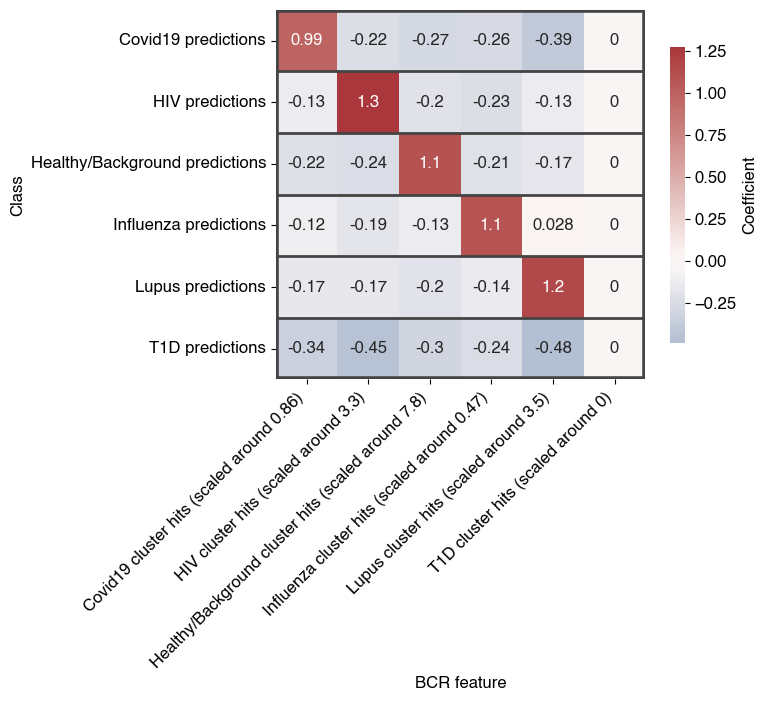

In [35]:
ax = sns.heatmap(
    coefs_table_bcr,
    center=0,
    cmap="vlag",
    annot=True,
    square=True,
    cbar_kws={"label": "Coefficient", "shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")

for i in range(coefs_table_bcr.shape[0] - 1):
    # Put some dividing lines between the rows
    ax.axhline(y=i + 1, color="#444", linewidth=2)

# Lines around the outer edge of the box
ax.axhline(y=0, color="#444", linewidth=4)
ax.axhline(y=coefs_table_bcr.shape[1], color="#444", linewidth=4)
ax.axvline(x=0, color="#444", linewidth=4)
ax.axvline(x=coefs_table_bcr.shape[0], color="#444", linewidth=4)

plt.ylabel("Class")
plt.xlabel("BCR feature")
genetools.plots.savefig(
    ax.get_figure(),
    clf_bcr.output_base_dir
    / f"{clf_bcr.fold_label_train}_model.coefficients.{clf_bcr.model_name}.fold_{clf_bcr.fold_id}.png",
    dpi=300,
)